In [1]:
import pickle 
import numpy as np

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib widget


with open('../../../moxie/data/processed/cleaned_pulse_dict_180622.pickle', 'rb') as file: 
    cleaned_dict = pickle.load(file)
with open('../../data/raw/new_elm_timings_catch.pickle', 'rb') as file: 
    JET_ELM_TIMINGS = pickle.load(file) 

## Plot 1: Show creating of dataset

#### $n_{e, sep}$ algorithm
- Find $r_{sep, prior} = \frac{1}{2}(r_{top} + r_{bot})$, where $r_{top}, r_{bot}$ are coordinates of electron density at the pedestal top and bottom respectively
- Find the first two points closest to $r_{sep, prior}$, $T_L$ and $T_R$ s.t. $T_R < 100 < T_L$
- Find $w_L, w_R$ for $T_{e, sep} = 100 \; [\text{eV}] = \frac{1}{2} (w_LT_L + w_RT_R)$
- Approximate $n_{e, sep} = \frac{1}{2} (w_Ln_L + w_Rn_R)$ for the density points $n_L, n_R$ corresponding to $T_L, T_R$

#### ELM Percentage

- Use ELM timings found in JET PDB
- $\text{ELM \%} = \frac{t_{\text{HRTS}} - t_{\text{Last ELM}}}{t_{\text{Next ELM}} - t_{\text{Last ELM}}}$ 

In [2]:
# 81795, 81836, 81837

relevant_pulse = cleaned_dict[str(81836)]

post_elm = relevant_pulse['profiles'][23], relevant_pulse['rmids'][23], relevant_pulse['elm_perc'][23], relevant_pulse['neseps'][23]
pre_elm = relevant_pulse['profiles'][24], relevant_pulse['rmids'][24], relevant_pulse['elm_perc'][24], relevant_pulse['neseps'][24]


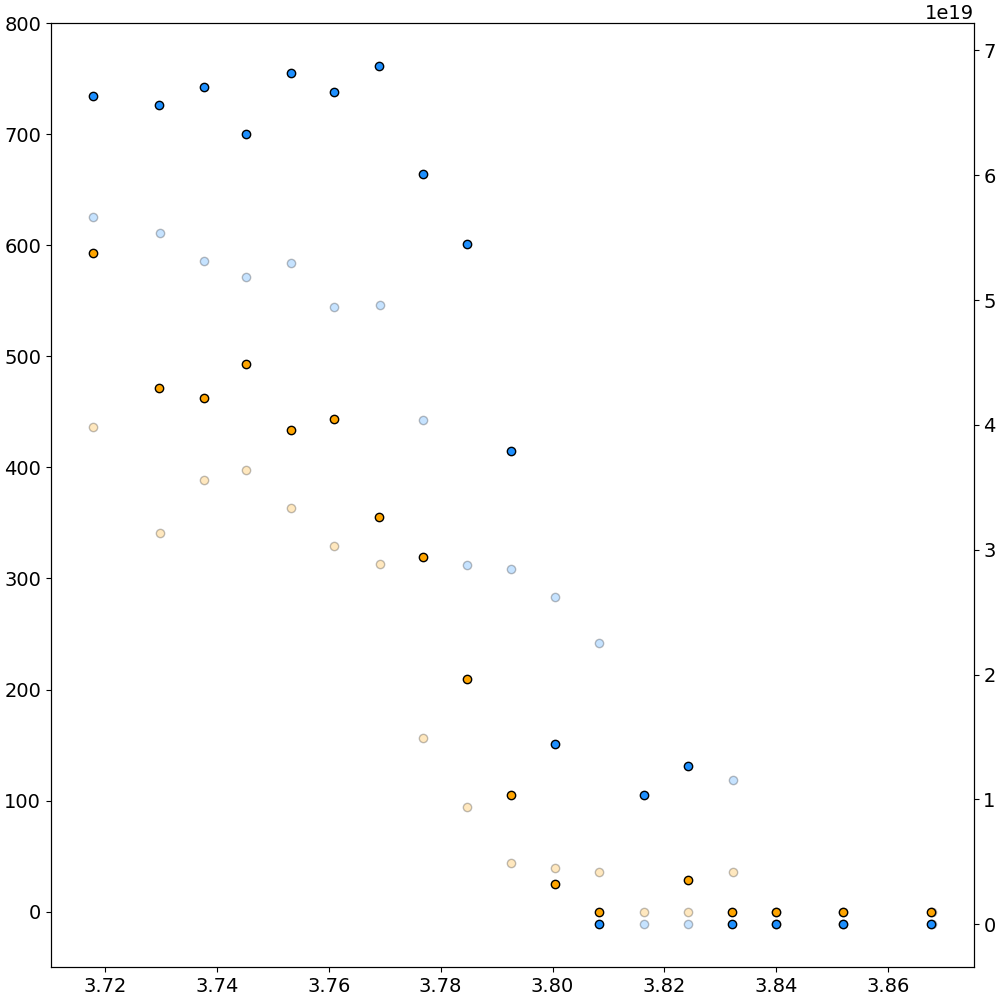

In [10]:
# for n, (ids, neseps, elms) in enumerate(zip(relevant_pulse['ids'],relevant_pulse['neseps'], relevant_pulse['elm_perc'])):
#     print(n, ids, neseps, elms)
    
# idx 23,24, ELM crash! 
plt.close('all')
fig, t_ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 10))

n_ax = t_ax.twinx()

t_ax.scatter(post_elm[1], post_elm[0][1], color='orange', edgecolor=(0, 0, 0), alpha=0.25, label='Post ELM')
n_ax.scatter(post_elm[1], post_elm[0][0], color='dodgerblue', edgecolor=(0, 0, 0), alpha=0.25, )


n_ax.scatter(pre_elm[1], pre_elm[0][0], color='dodgerblue', edgecolor=(0, 0, 0), label='Pre ELM')
t_ax.scatter(pre_elm[1], pre_elm[0][1], color='orange', edgecolor=(0, 0, 0), label='Pre ELM')

t_ax.set_ylim(-50,800)

"""
fig = plt.figure(constrained_layout=True, figsize=(10, 10))
gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0, wspace=0, top=0.95, bottom=0.05, left=0.17, right=0.845)

t_ax = fig.add_subplot(gs[1])
n_ax = fig.add_subplot(gs[0], sharex=t_ax)

"""
plt.show()